# Image processing

Required packages and their import.

> pip install numpy matplotlib opencv-python

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## What is an image?

### Dummy image creation from parametric equations

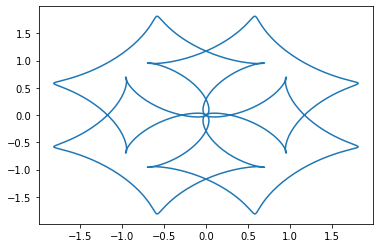

In [2]:
Nt = 1000

a = 1
b = 5

c = 1
d = 5

j = 3
k = 3

t = np.linspace(0, 2*np.pi, Nt)
x = np.cos(a*t) - np.cos(b*t)**j
y = np.sin(c*t) - np.sin(d*t)**k

plt.plot(x, y)
plt.show()


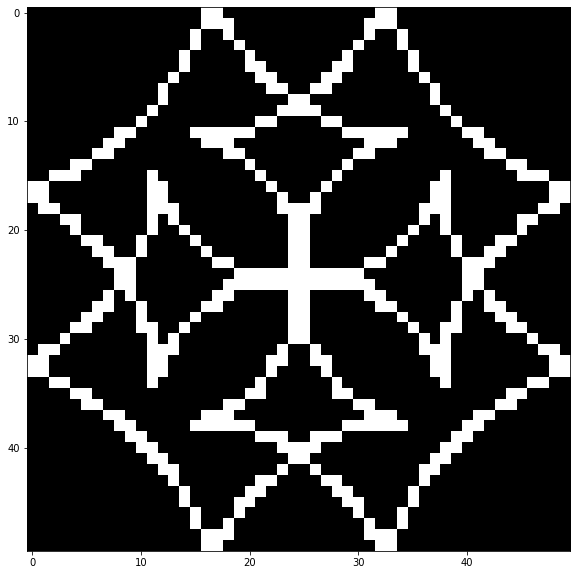

In [3]:
N = 50
x -= x.min()
y -= y.min() 
x /= x.max()
y /= y.max()

image = np.zeros((N, N), dtype="uint8")

for (xp, yp) in zip(x, y):
    xp = min(int(xp*N), N-1)
    yp = min(int(yp*N), N-1)
    image[int(xp), int(yp)] = 255

plt.figure(figsize=(10,10))
plt.imshow(image, cmap="gray")

### Use of the dummy image as a template for a bigger dummy image

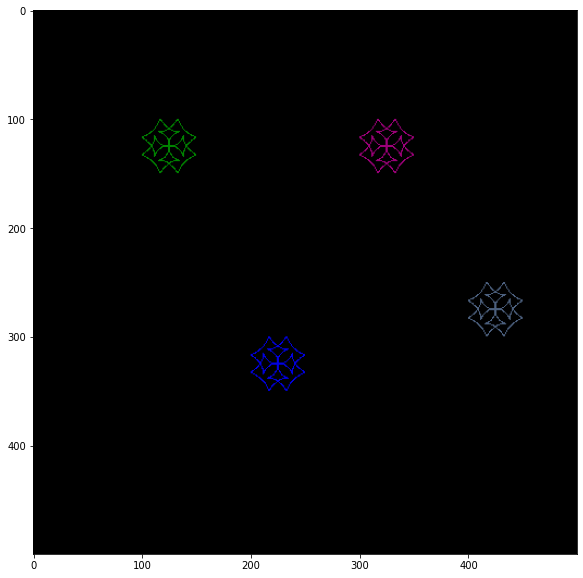

In [4]:
mask = image.copy()
h, w = mask.shape

N = 500
big_image = np.zeros((N, N, 3), dtype="uint8")


to_plot = [
    (100, 100, (255, 125, 0)),
    (300, 100, (100, 255, 135)),
    (400, 250, (180, 160, 130)),
    (200, 300, (255, 255, 30))
]

for xc, yc, color in to_plot:
    for idx, c in enumerate(color):
        big_image[yc:yc+h, xc:xc+w, idx] = mask * c 

plt.figure(figsize=(10,10))
plt.imshow(big_image, cmap="gray")

## Processing of a real images

### Open and show real image

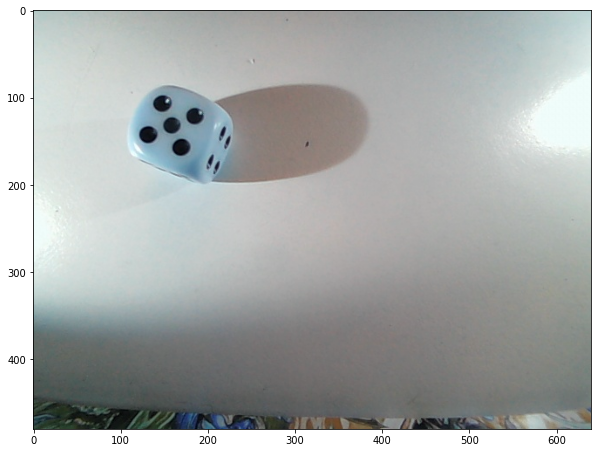

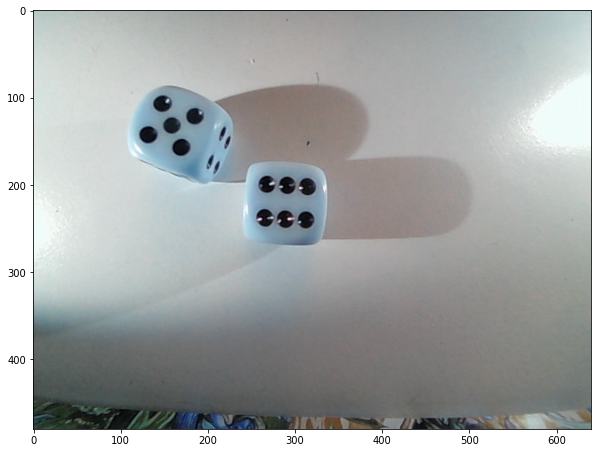

In [5]:
FILE_NAME = os.path.join('data', 'images', '6', '241b9816-86c9-4c47-9864-20245e5b9ae8.jpg')
BACKGROUND_NAME = os.path.join('data', 'images', 'background.jpg')

image = cv2.imread(FILE_NAME) 
image_background = cv2.imread(BACKGROUND_NAME)

plt.figure(figsize=(10,10))
plt.imshow(image_background)
plt.figure(figsize=(10,10))
plt.imshow(image)

### Grayscale conversion

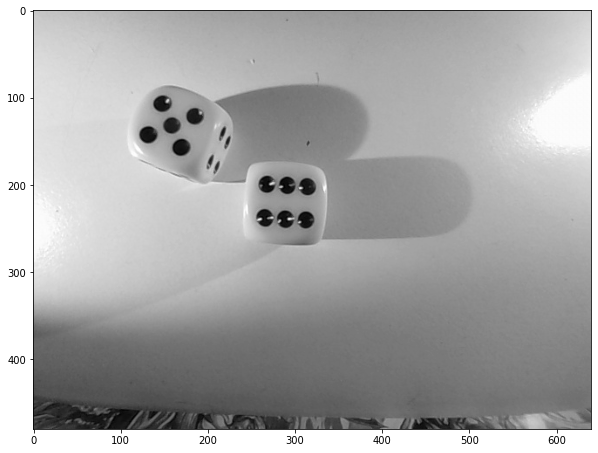

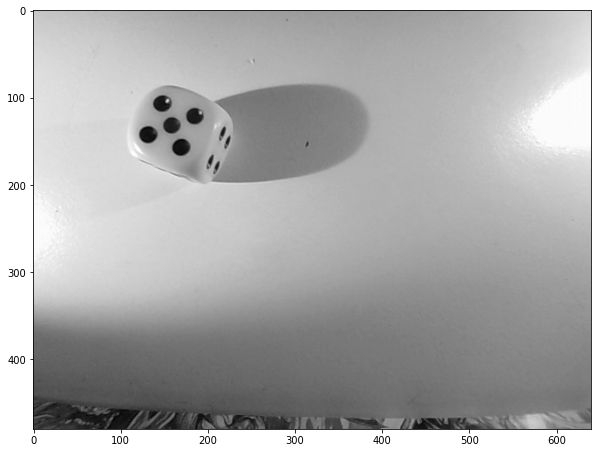

In [6]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(image_gray, cmap='gray', vmin=0, vmax=255)
background_gray =cv2.cvtColor(image_background, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(background_gray, cmap='gray', vmin=0, vmax=255)

### Background removal

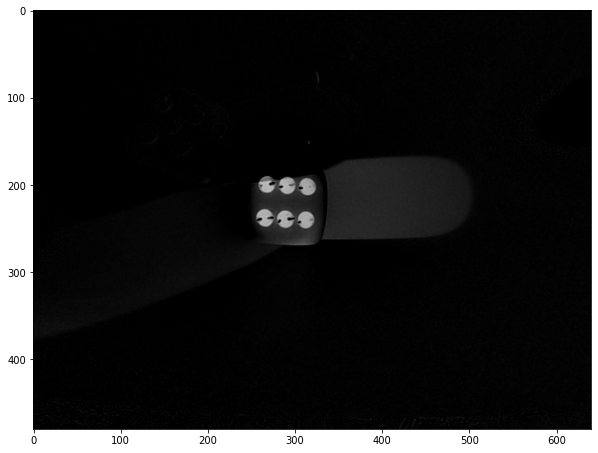

In [7]:
image_subtracted = cv2.subtract(background_gray, image_gray)
plt.figure(figsize=(10,10))
plt.imshow(image_subtracted, cmap='gray', vmin=0, vmax=255)

### Threshold

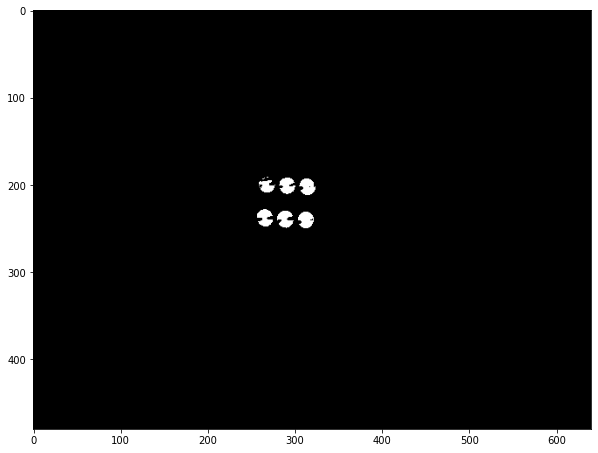

In [8]:
ret, image_threshold = cv2.threshold(image_subtracted, 120, 255, cv2.THRESH_BINARY)  # image threshold
plt.figure(figsize=(10,10))
plt.imshow(image_threshold, cmap='gray', vmin=0, vmax=255)

### Erosion and dilatation (morphological operations)

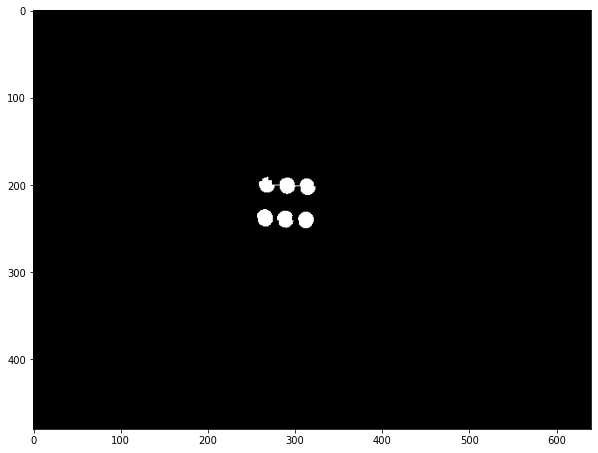

In [9]:
kernel = np.ones((3,3), np.uint8)  
ret = cv2.dilate(image_threshold, kernel, iterations=2)  
ret = cv2.erode(ret, kernel, iterations=2)  

plt.figure(figsize=(10,10))
plt.imshow(ret, cmap="gray")

### Contours

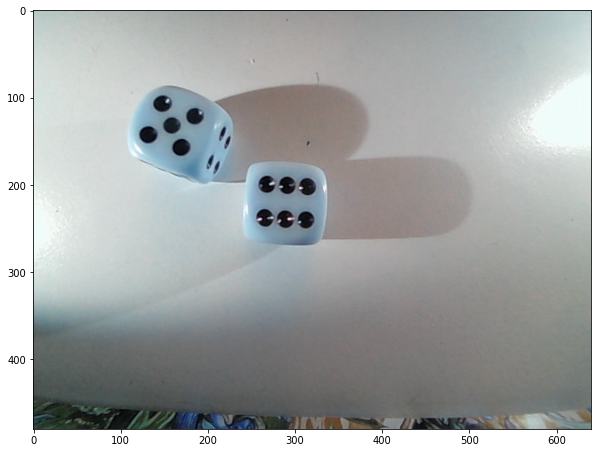

In [10]:
image_show = image.copy()
contours, hierarchy = cv2.findContours(image_threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
target_contours = []
for contour in contours:
    contour_area = cv2.contourArea(contour)  # estimate contour area
    if contour_area > 100:
            target_contours.append(contour)
cv2.drawContours(image, target_contours, -1, (255, 255, 0), 2)  # draw contour into color image
plt.figure(figsize=(10,10))
plt.imshow(image_show)

Number of countours found:

In [11]:
print(len(target_contours))

6


### Template matching

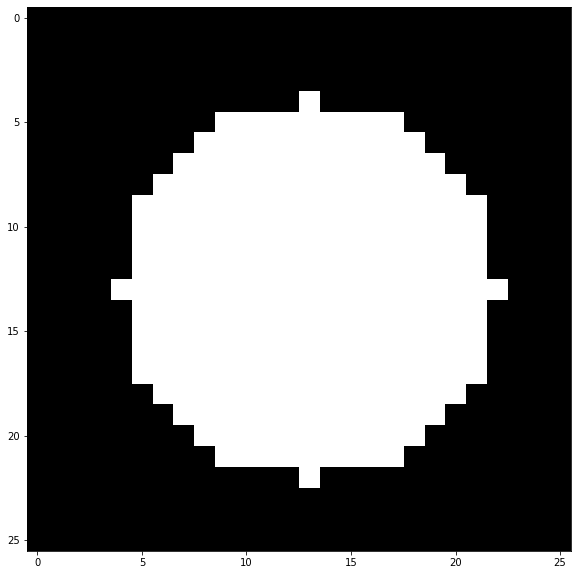

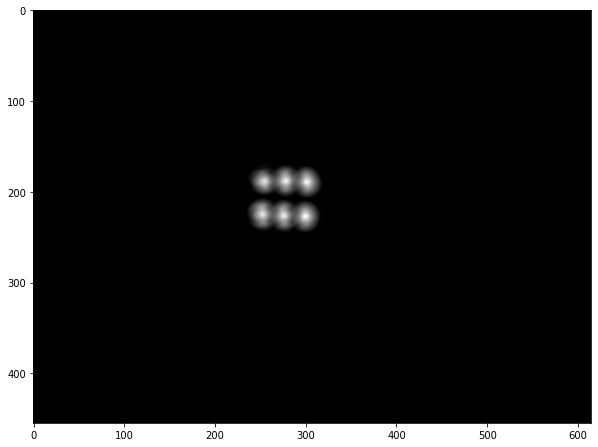

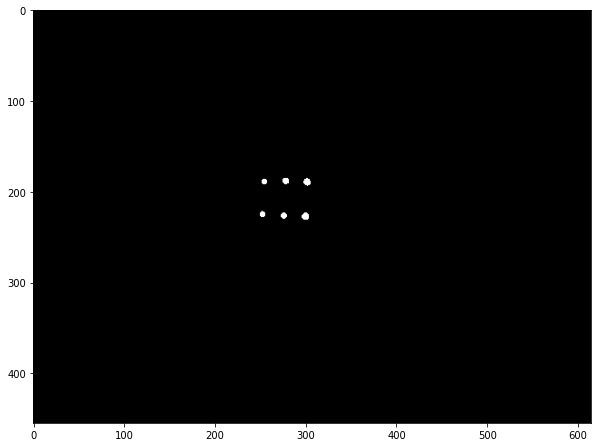

In [12]:
image_show = image.copy()

N = 26
temp = np.zeros((N, N), dtype="uint8")

temp = cv2.circle(temp, (N // 2, N // 2), (N // 2) - 4, 255, -1) 

res_corr = cv2.matchTemplate(image_threshold, temp, cv2.TM_CCORR_NORMED)


ret, res = cv2.threshold(res_corr, 0.7, 1, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.imshow(temp, cmap="gray")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(res_corr, cmap="gray")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(res, cmap="gray")
plt.show()

## Complete solution

In [13]:
def detect_points(filename, backgroundname):
    # load images
    image = cv2.imread(filename) 
    image_background = cv2.imread(backgroundname)
    # convert to gray
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    background_gray =cv2.cvtColor(image_background, cv2.COLOR_BGR2GRAY)
    # remove background
    image_subtracted = cv2.subtract(background_gray, image_gray)
    # threshold
    ret, image_threshold = cv2.threshold(image_subtracted,
                                         100, 255, cv2.THRESH_BINARY)
    # find contours
    contours, hierarchy = cv2.findContours(image_threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    target_contours = []
    for contour in contours:
        contour_area = cv2.contourArea(contour)  
        if contour_area > 100:
                target_contours.append(contour)
    # return number of points
    return [len(target_contours), image_threshold]
    
    
FILE_NAME = os.path.join('data', 'images', '6', '241b9816-86c9-4c47-9864-20245e5b9ae8.jpg')
BACKGROUND_NAME = os.path.join('data', 'images', 'background.jpg')

result, image = detect_points(FILE_NAME, BACKGROUND_NAME)

print(result)

6


In [14]:
import time

t0 = time.time()
filenames = []
for d,_, file_list in os.walk("data/"):
    for f in file_list:
        if f.endswith(".jpg") and not "background" in f and not "checkpoint" in f:
            filename = os.path.join(d, f)
            filenames.append(filename)

for filename in filenames:
    result, image = detect_points(filename, BACKGROUND_NAME)
    correct = int(filename.split("/")[2])
    print(correct == result, filename,)
    
t1 = time.time()
print()
print("Estimated time:", t1 - t0)
print("Time per picture:", (t1 - t0) / len(filenames))
print("Possible FPS:", len(filenames) / (t1 - t0))
        
            

True data/images/1/0a71cecc-0a63-49ca-bf87-99bc321dee21.jpg
True data/images/1/86018ef6-a46f-4572-ae7d-72faf5572fbc.jpg
True data/images/1/b4c3491f-f681-4f31-aa6c-ef1ed4d8f355.jpg
True data/images/2/5a683e61-7431-40f9-a0bb-40ba776b875c.jpg
True data/images/2/24b6a9c4-c1b6-4c83-94f1-c2204fd23df6.jpg
True data/images/2/20ccfa0b-4957-4ade-9147-f247c5f3ba35.jpg
True data/images/3/0fa64b9a-6103-4011-83b9-e5f50d8544a3.jpg
True data/images/3/a076fa7d-7047-4a8e-8076-3267220fe657.jpg
True data/images/3/47567e3b-1519-4f2c-9b73-a2546eedbdb8.jpg
True data/images/6/241b9816-86c9-4c47-9864-20245e5b9ae8.jpg
True data/images/6/c28d4919-ecb8-4d35-b0c8-78020efa71e8.jpg
True data/images/6/5a0af0c1-9293-433d-9b63-e38df70b0a78.jpg
True data/images/4/05c2d4ca-3907-4535-b6d3-25a47cedcee3.jpg
True data/images/4/d716fccf-3b66-4b1e-a7b5-e1d1b46d8ab9.jpg
True data/images/4/0dec11c8-7730-4e69-9d5d-9dd6797de5c8.jpg
True data/images/5/3b7f31ec-ce43-4cc8-846f-eedf1e7f3acc.jpg
True data/images/5/60fd2388-d123-4daa-81